# PDI Analysis

This script investigates the output of our live stream detections in order to gain useful insights.
The goal is to create a "Physical Distancing Index" (`PDI`) that shows the trends and changes at
a camera feed while removing noise and perturbations from unwanted effects.

In this directory is a CSV file containing historical data for 7 cams.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

To start, let's read in the data.

There are three columns in the data:
- `stream_name`: the source camera location
- `timestamp`: the epoch time (in seconds) when the camera was sampled
- `count`: the number of objects detected in the image (people, cars, bicycles, ...)

In [2]:
data = pd.read_csv("counts.csv")

data.tail(10)

,stream_name,timestamp,count
6265,abbey_road,1585766512,7
6266,times_square,1585766532,34
6267,prague,1585766537,0
6268,dublin,1585766548,10
6269,new_jersey,1585767400,2
6270,abbey_road,1585767413,6
6271,times_square,1585767427,29
6272,prague,1585767432,0
6273,fort_lauderdale,1585767446,0
6274,dublin,1585767450,5


Next we can reorganize the data by stream and visualize it

In [3]:
data_dict = {
    stream_name: {
        "timestamp": data[data["stream_name"]==stream_name]["timestamp"],
        "count": data[data["stream_name"]==stream_name]["count"]
    } for stream_name in sorted(list(set(data["stream_name"])))
}

print("Stream sources:")
print(list(data_dict.keys()))

Stream sources:
['abbey_road', 'dublin', 'fort_lauderdale', 'new_jersey', 'new_orleans', 'prague', 'times_square']


The data was not sampled uniformly. Sampling is denser starting around mid-march and there appears to be a gap for a day or two in late march.

Still, we immediately can start to see some interesting things.

First off, there are far more detections on the `times_square` feed than any other, which is reassuring.

We also notice a rather dramatic trend of decreasing count around mid-march.

Despite the trend, there is still a lot of noise in the data. Even before the pandemic, there are times of day that a camera may not be busy. We can certainly clean up this signal for a clearer and more meaningful interpretation.

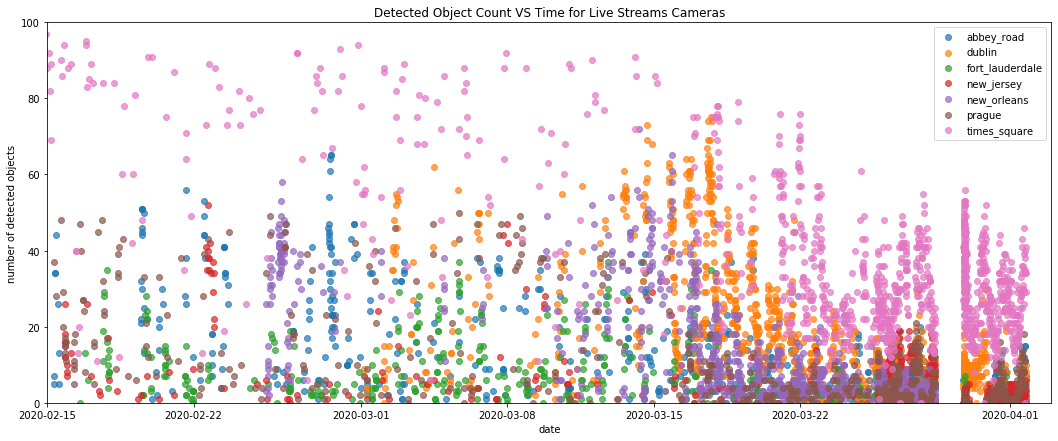

In [4]:
plt.figure(figsize=(18, 7))
for stream_name, d in data_dict.items():
    timestamps, counts = d["timestamp"], d["count"]
    datetimes = pd.to_datetime(timestamps, unit='s')
    plt.scatter(datetimes, counts, label=stream_name, alpha=0.7)
plt.xlabel("date")
plt.ylabel("number of detected objects")
plt.xlim([pd.Timestamp('2020-02-15'), pd.Timestamp('2020-04-03')])
plt.ylim([0, 100])
plt.title("Detected Object Count VS Time for Live Streams Cameras")
plt.legend();

This helper function will allow us to quickly visualize our candidate `PDI` statistics.

One implementation detail to mention here is that this plot function normalizes the magnitude of the PDI for each stream, such that they all have a maximum of 100. This is because the the overall magnitude is heavily dependent on both the activity in the city and more specifically the activity at the exact location of the camera, but what we really care about is relative change. This will help us with visualizing our different statistics.

In [5]:
def plot_pdi(data_dict, pdi_func, version):
    plt.figure(figsize=(18, 7))

    for stream_name, d in data_dict.items():
        timestamps, counts = d["timestamp"], d["count"]
        datetimes = pd.to_datetime(timestamps, unit='s')
        datetimes, pdis = pdi_func(datetimes, counts)
        # normalize PDIs
        normalized_pdis = np.array(pdis) * 100 / np.max(pdis)
        plt.plot(datetimes, normalized_pdis, label=stream_name)

    plt.xlabel("date")
    plt.ylabel("candidate PDI V%d" % version)
    plt.xlim([pd.Timestamp('2020-02-15'), pd.Timestamp('2020-04-03')])
    plt.ylim([0, 100])
    plt.legend()

We can clean up the noise in this signal by averaging over time.

In [6]:
def create_pdi_func(window_days, avg_fcn):
    def pdi_func(datetimes, counts):
        pdis = np.zeros(len(counts))

        for i, time in enumerate(datetimes):
            # get all counts within the temporal window
            start_time = time - pd.Timedelta(days=window_days)
            window_counts = counts[(start_time <= datetimes) & (datetimes <= time)]

            # average over this window
            pdis[i] = avg_fcn(window_counts)

        return datetimes, pdis

    return pdi_func

To start, let's look at all counts in the past **1 day** and **average** them

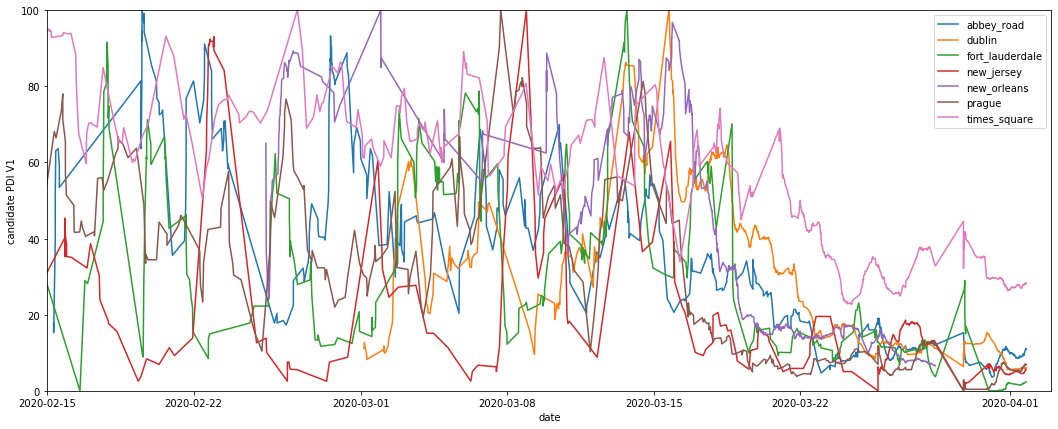

In [7]:
# number of days to average counts over
WINDOW_DAYS = 1

# a function that averages the counts within a window
AVG_FCN = np.mean

pdi_func_v1 = create_pdi_func(WINDOW_DAYS, AVG_FCN)

plot_pdi(data_dict, pdi_func_v1, version=1)

Hmmm...not great, but perhaps we're on to something. We can increase the averaging window to **3 days** and instead take the $L^2$ **(euclidean) norm**.

The [$L^p$ norm](https://en.wikipedia.org/wiki/Lp_space) weighs each sample by its magnitude. The higher $p$ is, the more weight is given to larger values. $L^1$ is equivalent to the mean (each sample has the same weight). $L^\infty$ is equivalent to choosing the maximum.

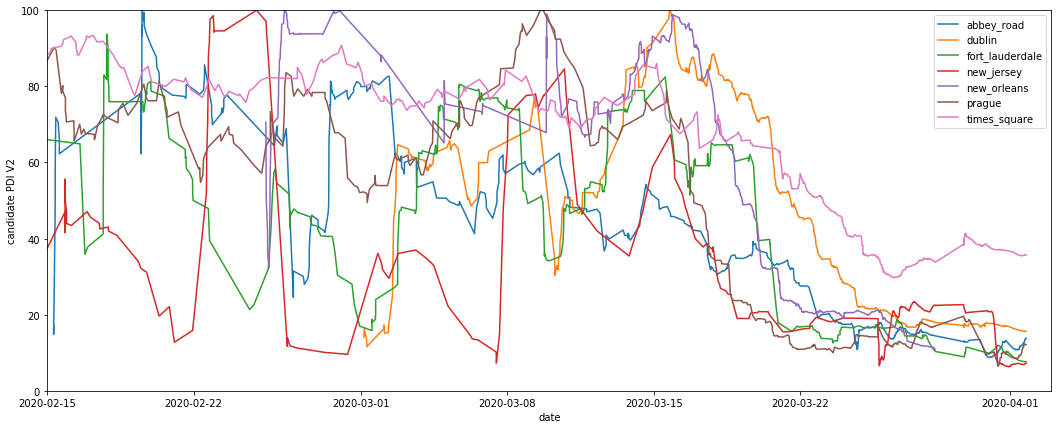

In [8]:
# number of days to average counts over
WINDOW_DAYS = 3

# p-norm value for normalizing (LP=2 -> euclidean norm)
LP = 2

# a function that averages the counts within a window
AVG_FCN = lambda x: np.linalg.norm(x, ord=LP) / (len(x) ** (1 / LP)) 

pdi_func_v2 = create_pdi_func(WINDOW_DAYS, AVG_FCN)

plot_pdi(data_dict, pdi_func_v2, version=2)

That's looking a better! We can take the output from `pdi_func_v2` and do a bit of further processing.

Using a simple rectangular filter we can smooth out the plot. In the code below, a larger `SMOOTHING_WIDTH` will smooth out the jaggedness but at a cost of reducing the resolution of transients, i.e. smearing any abrupt changes over a longer time.

`40` seems like a pretty good value, but feel free to play with this.

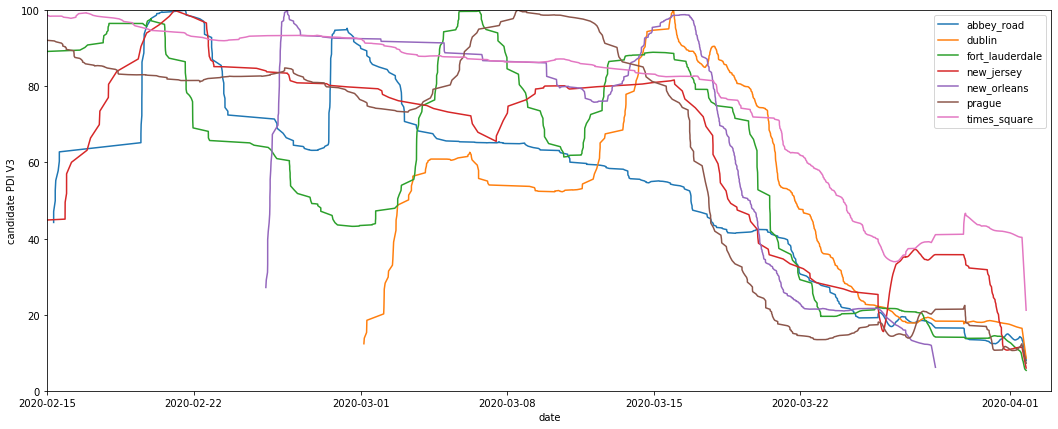

In [9]:
SMOOTHING_WIDTH = 40

def pdi_func_v3(datetimes, counts):
    datetimes, pdis = pdi_func_v2(datetimes, counts)
    
    if SMOOTHING_WIDTH:
        kernel_size = min(SMOOTHING_WIDTH, len(pdis))
        kernel = np.ones(kernel_size) / kernel_size
        pdis = list(np.convolve(pdis, kernel, mode="same"))

    return datetimes, pdis

plot_pdi(data_dict, pdi_func_v3, version=3)

Finally, we can omit the first `WINDOW_DAYS` days of data for each series, which spike up as an artifact of the filtering, which has not yet reached steady state.

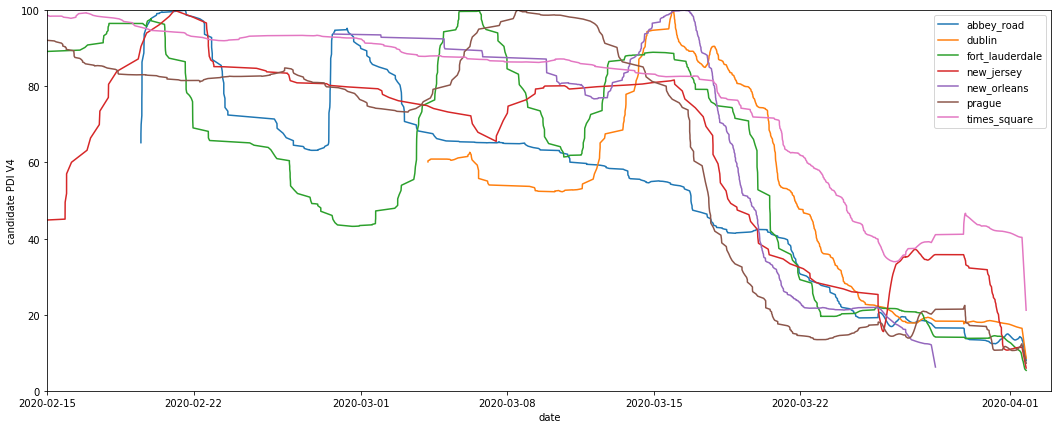

In [11]:
def pdi_func_v4(datetimes, counts):
    datetimes, pdis = pdi_func_v3(datetimes, counts)
    
    # Omit startup values
    startup_time = datetimes.iloc[0] + pd.Timedelta(days=WINDOW_DAYS)
    indices = np.argwhere(datetimes > startup_time)
    skip = indices[0, 0] if indices.size != 0 else 0

    return datetimes[skip::], pdis[skip::]

plot_pdi(data_dict, pdi_func_v4, version=4)

That's looking pretty good! We can already start go get some useful insights. For example, it appears that Prague was the first city to start the dramatic downward trend in PDI at around March 15th. And while New York City (`times_square`) had a sudden dropoff, it still continues to have more activity relative to the other cameras. And Ford Lauderdale, of which the camera is on a beach, had some oscilating levels of activity even before March 15th which were due to varying weather. Similarly, the low initial PDI at Seaside Heights (`new_jersey`) was due to some bad weather in mid February.